# YOLOv5 Face mask detection

This notebook utilize YOLOv5 model to do the face mask detection task.  
Code is modified from https://www.kaggle.com/rkuo2000/yolov5-facemask

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'COMP4211/Project1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/COMP4211/Project1


## YOLOv5 clone

In [2]:
%cd working/

/content/drive/My Drive/COMP4211/Project1/working


In [ ]:
!git clone https://github.com/ultralytics/yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/My Drive/COMP4211/Project1/working/yolov5


In [3]:
%cd yolov5

/content/drive/My Drive/COMP4211/Project1/working/yolov5


In [ ]:
!mkdir -p Dataset/FaceMask/Images
!mkdir -p Dataset/FaceMask/Labels

In [ ]:
!unzip -o /content/drive/My\ Drive/$FOLDERNAME/archive.zip -d /content/drive/My\ Drive/$FOLDERNAME/input/face-mask-detection

Archive:  /content/drive/My Drive/COMP4211/Project1/archive.zip
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss0.xml  
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss1.xml  
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss10.xml  
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss100.xml  
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss101.xml  
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss102.xml  
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss103.xml  
  inflating: /content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss104.xml  
  inflating: /content

In [ ]:
# copy image files from input to dataset
!cp -rf /content/drive/My\ Drive/$FOLDERNAME/input/face-mask-detection/images/* Dataset/FaceMask/Images

In [ ]:
# YOLO format dataset
!mkdir -p Dataset/images Dataset/labels

## Create YOLO format dataset

In [6]:
!pip install bs4

In [5]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from bs4 import BeautifulSoup
from shutil import copyfile

In [7]:
FILE_ROOT = '/content/drive/My Drive/{}/input/face-mask-detection/'.format(FOLDERNAME)
IMAGE_PATH = FILE_ROOT + 'images'
ANNOTATIONS_PATH = FILE_ROOT + 'annotations'

DATA_ROOT = 'Dataset/'
LABELS_ROOT = DATA_ROOT + 'FaceMask/Labels'
IMAGES_ROOT = DATA_ROOT + 'FaceMask/Images'  

DEST_IMAGES_PATH = 'images'
DEST_LABELS_PATH = 'labels'

In [8]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

**Convert the annotations from .xml format to YOLO .txt format.**

In [ ]:
def cord_converter(size, box):
    '''
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    '''
    # Box coordinates must be in normalized xywh format (from 0 - 1) for training YOLO
    
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    
    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    dw = np.float32(1.0 / int(size[0]))
    dh = np.float32(1.0 / int(size[1]))

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box, print_path = 0):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    if print_path:
        print(save_file_name)
    file = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0])

        new_box = cord_converter(size, box[1:])

        file.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file.flush()
    file.close()
    
def generate_box(obj):
    
    cls_name = obj.find('name').text
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [cls_name, xmin, ymin, xmax, ymax]

def get_xml_data(file_path, img_xml_file, print_path = 0):
    img_path = file_path + '/' + img_xml_file + '.xml'
    if print_path:
        print(img_path)

    with open(img_path) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        img_box = []
        for box in objects:
            img_box.append(generate_box(box))
        
        img_size = soup.find('size')
        img_w = int(img_size.find('width').text)
        img_h = int(img_size.find('height').text)
        
        save_file(img_xml_file, [img_w, img_h], img_box, print_path)

In [ ]:
files = os.listdir(ANNOTATIONS_PATH)
counter = 0
for file in files:
    counter += 1
    if counter % 50 == 0:
        print('Number ' + str(counter) + ':')
        print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0], counter % 50 == 0)

Number 50:
file name:  maksssksksss142.xml
/content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss142.xml
Dataset/FaceMask/Labels/maksssksksss142.txt
Number 100:
file name:  maksssksksss188.xml
/content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss188.xml
Dataset/FaceMask/Labels/maksssksksss188.txt
Number 150:
file name:  maksssksksss232.xml
/content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss232.xml
Dataset/FaceMask/Labels/maksssksksss232.txt
Number 200:
file name:  maksssksksss278.xml
/content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss278.xml
Dataset/FaceMask/Labels/maksssksksss278.txt
Number 250:
file name:  maksssksksss322.xml
/content/drive/My Drive/COMP4211/Project1/input/face-mask-detection/annotations/maksssksksss322.xml
Dataset/FaceMask/Labels/maksssksksss322.txt
Number 300:
file name:  maksssksksss368.xml
/content/drive/My

## Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('Dataset/FaceMask/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=4211)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=4211)

print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 853
train : 682
val   : 85
test  : 86


In [ ]:
# Copy data to train, val and test set respectively
def copy_data(file_list, img_labels_root, imgs_source, type):

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [ ]:
copy_data(train_list, LABELS_ROOT, IMAGES_ROOT, 'train')
copy_data(val_list,   LABELS_ROOT, IMAGES_ROOT, 'val')
copy_data(test_list,  LABELS_ROOT, IMAGES_ROOT, 'test')

Path Dataset/images/train is not exit
Path Dataset/labels/train is not exit
Path Dataset/images/val is not exit
Path Dataset/labels/val is not exit
Path Dataset/images/test is not exit
Path Dataset/labels/test is not exit


## Create facemask.yaml

In [ ]:
!echo -e "train: Dataset/images/train\n" > data/facemask.yaml
!echo -e "val:   Dataset/images/val\n" >> data/facemask.yaml
!echo -e "nc : 3\n" >> data/facemask.yaml
!echo -e "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']\n" >> data/facemask.yaml

!cat data/facemask.yaml

train: Dataset/images/train

val:   Dataset/images/val

nc : 3

names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']



## Train YOLOv5

In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 645kB 8.6MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
!pip install wandb

     |████████████████████████████████| 2.1MB 19.5MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 163kB 47.2MB/s 
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=7f003149c9e0e62b1641e039ae39e8ded919c29694e7a0d4e0b4c0ba1acecce6
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=93677ff636cb63e21b46521b612075fd087ad961f43b790b23318e6397fc7b96
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
!python train.py --img 320 --batch 16 --epochs 300 --device 0 --data data/facemask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='models/yolov5s.yaml', data='data/facemask.yaml', device='0', entity=None, epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[320, 320], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp2', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-04-25 10:23:47.810308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successf

In [ ]:
# save trained weights for detection
!cp runs/train/exp2/weights/best.pt weights

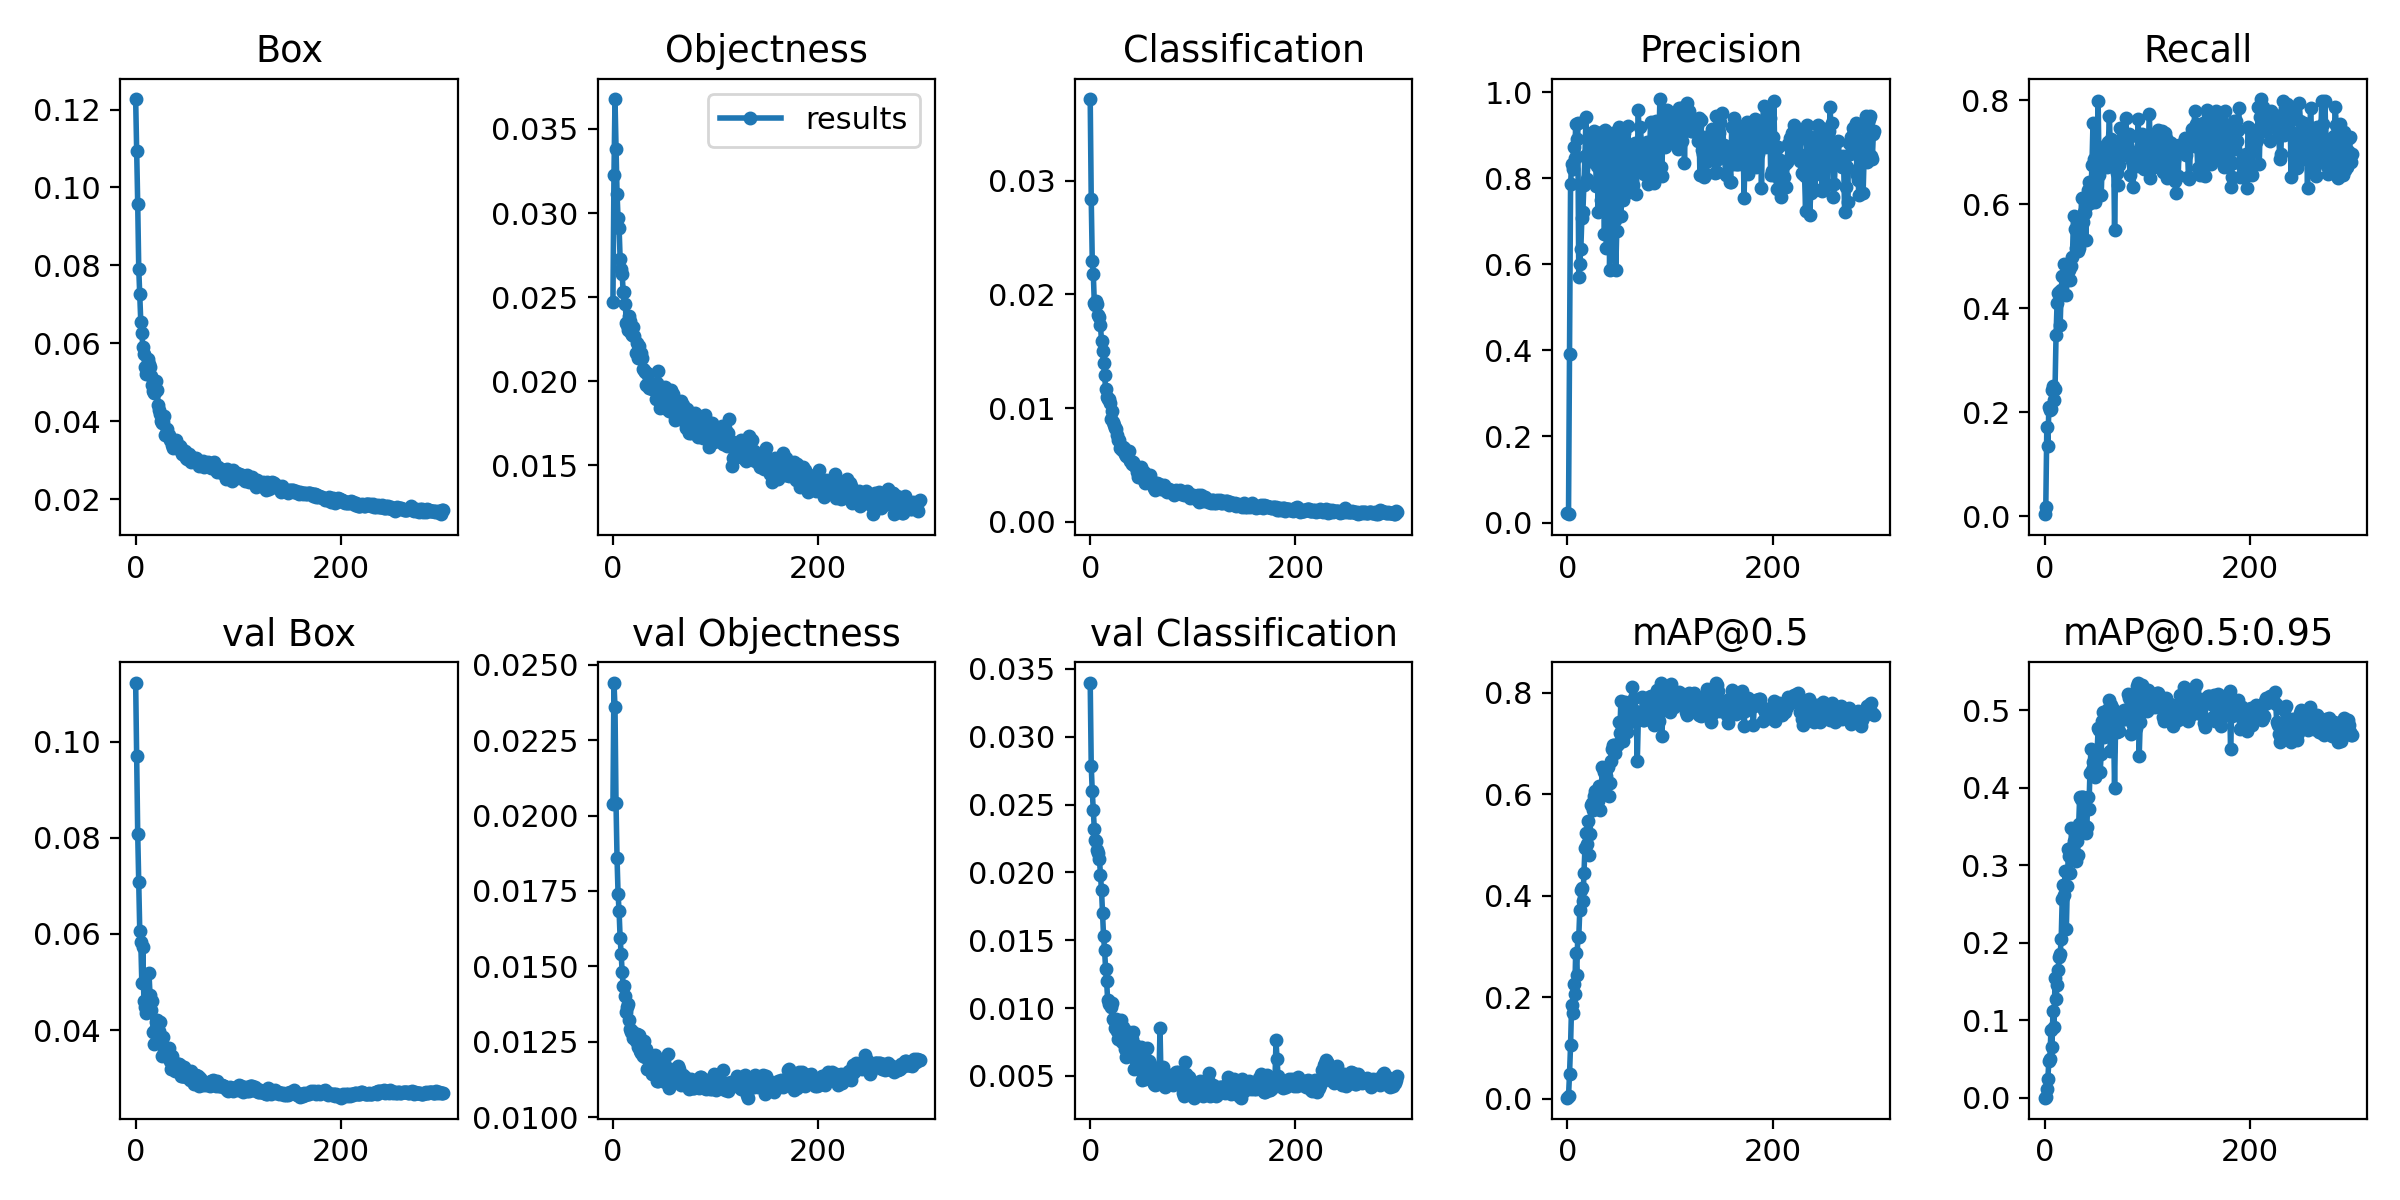

In [ ]:
from utils.plots import plot_results 
from IPython.display import Image, clear_output  # to display images

plot_results(save_dir='runs/train/exp2')  # plot results.txt as results.png
Image(filename='runs/train/exp2/results.png', width=800)

## Test YOLOv5 

In [ ]:
!echo -e "val: Dataset/images/test\n" > data/test.yaml
!echo -e "nc : 3\n" >> data/test.yaml
!echo -e "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']\n" >> data/test.yaml

!cat data/test.yaml

val: Dataset/images/test

nc : 3

names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']



In [ ]:
!python test.py --data data/test.yaml --img-size 320 --conf 0.36 --weights weights/best.pt --save-txt

Namespace(augment=False, batch_size=32, conf_thres=0.36, data='data/test.yaml', device='', exist_ok=False, img_size=320, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='val', verbose=False, weights=['weights/best.pt'])
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/drive/My Drive/COMP4211/Project1/working/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPS
val: Scanning 'Dataset/labels/test.cache' images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 856793.69it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [0

In [ ]:
%cd yolov5

/content/drive/My Drive/COMP4211/Project1/working/yolov5


## Train different configurations of YOLOv5

In [ ]:
!python train.py --img 640 --batch 32 --epochs 170 --device 0 --data data/facemask.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt --resume

github: ⚠️ WARNING: code is out of date by 5 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=False, cfg='models/yolov5m.yaml', data='data/facemask.yaml', device='0', entity=None, epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp12', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, weights='yolov5m.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-04-26 

In [ ]:
!python train.py --img 640 --batch 32 --epochs 300 --device 0 --data data/facemask.yaml --cfg models/yolov5m.yaml --weights yolov5m.pt --resume

github: ⚠️ WARNING: code is out of date by 5 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
Resuming training from ./runs/train/exp12/weights/last.pt
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=32, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='data/facemask.yaml', device='0', entity=None, epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=True, save_dir='runs/train/exp12', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=32, upload_dataset=False, weights='./runs/train/exp12/weights/last.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --

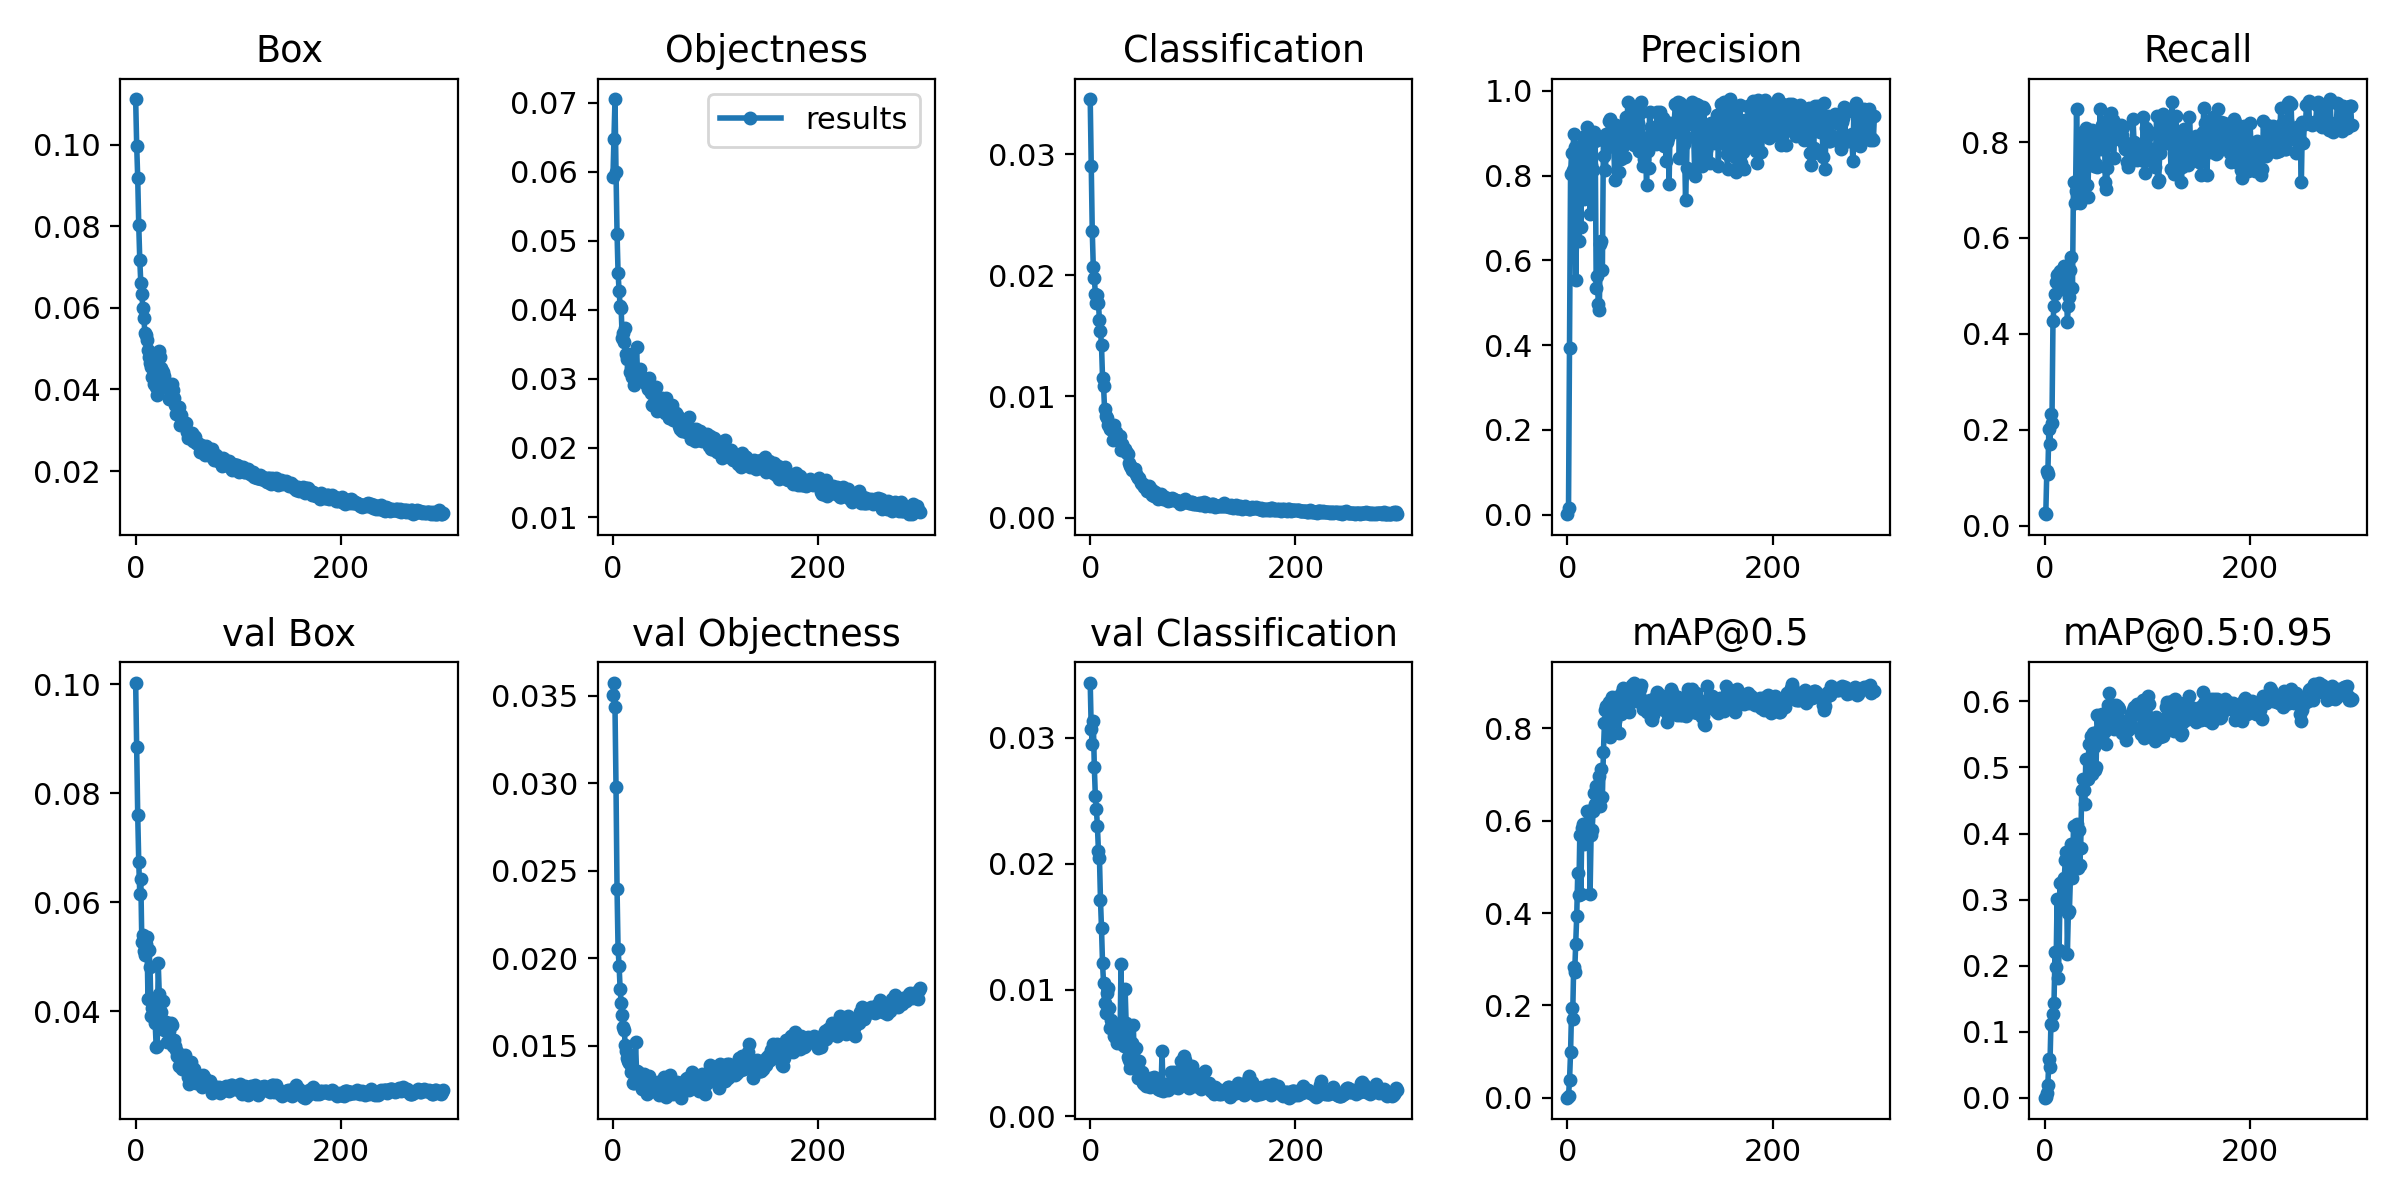

In [10]:
from utils.plots import plot_results 
from IPython.display import Image, clear_output  # to display images

plot_results(save_dir='runs/train/exp12')  # plot results.txt as results.png
Image(filename='runs/train/exp12/results.png', width=800)

In [ ]:
!python test.py --data data/test.yaml --img-size 640 --conf 0.218 --weights runs/train/exp12/weights/best.pt --save-txt

Namespace(augment=False, batch_size=32, conf_thres=0.218, data='data/test.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='val', verbose=False, weights=['runs/train/exp12/weights/best.pt'])
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 308 layers, 21045720 parameters, 0 gradients, 50.3 GFLOPS
val: Scanning 'Dataset/labels/test.cache' images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 862942.93it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:21<00:00,  7.28s/it]
                 all          86         462       0.897       0.747       0.739       0.498
           With_Mask          86         335       0.922       0.955       0.952       0.687
        Without_Mask          86         111       0

## Imbalanced Dataset

In [21]:
# Find all labels in the train set with at least one 'mask_weared_incorrect' object
# copy them to a new train set

imgs_source = 'Dataset/images/train'
labels_source = 'Dataset/labels/train'

imgs_destination = 'Dataset/images/train_incorrect_mask'
labels_destination = 'Dataset/labels/train_incorrect_mask'

file_list = os.listdir(labels_source)

counter = 0

for file in file_list:
    file_path = labels_source + '/' + file
    with open(file_path, 'r') as f:
        data = f.read()
        # if counter == 1:
        #     print(data)
        boxes = data.split()
        if '2' in boxes:
            counter += 1
            print(file)
            img_name = file.replace('.txt', '')
            img_src_file = imgs_source + '/' + img_name + '.png'
            label_src_file = file_path

            img_dest_file = imgs_destination + '/' + img_name + '.png'
            label_dest_file = labels_destination + '/' + img_name + '.txt'
            copyfile(img_src_file, img_dest_file)
            copyfile(label_src_file, label_dest_file)
print(f'{counter} images in the new train set')

maksssksksss459.txt
maksssksksss718.txt
maksssksksss498.txt
maksssksksss613.txt
maksssksksss815.txt
maksssksksss717.txt
maksssksksss276.txt
maksssksksss29.txt
maksssksksss431.txt
maksssksksss623.txt
maksssksksss386.txt
maksssksksss562.txt
maksssksksss514.txt
maksssksksss282.txt
maksssksksss139.txt
maksssksksss467.txt
maksssksksss634.txt
maksssksksss495.txt
maksssksksss484.txt
maksssksksss564.txt
maksssksksss156.txt
maksssksksss761.txt
maksssksksss151.txt
maksssksksss132.txt
maksssksksss603.txt
maksssksksss255.txt
maksssksksss440.txt
maksssksksss424.txt
maksssksksss741.txt
maksssksksss545.txt
maksssksksss428.txt
maksssksksss748.txt
maksssksksss832.txt
maksssksksss272.txt
maksssksksss9.txt
maksssksksss11.txt
maksssksksss693.txt
maksssksksss199.txt
maksssksksss371.txt
maksssksksss253.txt
maksssksksss2.txt
maksssksksss782.txt
maksssksksss647.txt
maksssksksss728.txt
maksssksksss673.txt
maksssksksss206.txt
maksssksksss698.txt
maksssksksss24.txt
maksssksksss657.txt
maksssksksss130.txt
maksssk

In [24]:
!echo -e "train: Dataset/images/train_incorrect_mask\n" > data/facemask_incorrect.yaml
!echo -e "val:   Dataset/images/val\n" >> data/facemask_incorrect.yaml
!echo -e "nc : 3\n" >> data/facemask_incorrect.yaml
!echo -e "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']\n" >> data/facemask_incorrect.yaml

!cat data/facemask_incorrect.yaml

train: Dataset/images/train_incorrect_mask

val:   Dataset/images/val

nc : 3

names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']



In [9]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=21452c2cb13f6382833149005568be5b473ca3a99a3d8c06734d08035571ae8d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.6 GB  |     Proc size: 269.7 MB
GPU RAM Free: 7609MB | Used: 2MB | Util   0% | Total     7611MB


In [ ]:
!python train.py --img 640 --batch 8 --epochs 30 --data data/facemask_incorrect.yaml --cfg models/yolov5m.yaml --weights runs/train/exp12/weights/best.pt

github: ⚠️ WARNING: code is out of date by 7 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla P4, 7611.9375MB)

Namespace(adam=False, artifact_alias='latest', batch_size=8, bbox_interval=-1, bucket='', cache_images=False, cfg='models/yolov5m.yaml', data='data/facemask_incorrect.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp22', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=8, upload_dataset=False, weights='runs/train/exp12/weights/best.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http:

In [11]:
!python test.py --data data/test.yaml --img-size 640 --conf 0.168 --weights runs/train/exp22/weights/best.pt --save-txt

Namespace(augment=False, batch_size=32, conf_thres=0.168, data='data/test.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='val', verbose=False, weights=['runs/train/exp22/weights/best.pt'])
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla P4, 7611.9375MB)

Fusing layers... 
Model Summary: 308 layers, 21045720 parameters, 0 gradients, 50.3 GFLOPS
val: Scanning 'Dataset/labels/test.cache' images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 727238.19it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:20<00:00,  6.68s/it]
                 all          86         462       0.862        0.75        0.74       0.499
           With_Mask          86         335       0.912       0.955       0.952       0.685
        Without_Mask          86         111       

## Model Ensembling

In [6]:
!python test.py --data data/test.yaml --img-size 640 --conf 0.168 --weights runs/train/exp22/weights/best.pt runs/train/exp12/weights/best.pt --save-txt

Namespace(augment=False, batch_size=32, conf_thres=0.168, data='data/test.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='val', verbose=False, weights=['runs/train/exp22/weights/best.pt', 'runs/train/exp12/weights/best.pt'])
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CPU

Fusing layers... 
Model Summary: 308 layers, 21045720 parameters, 0 gradients, 50.3 GFLOPS
Fusing layers... 
Model Summary: 308 layers, 21045720 parameters, 0 gradients, 50.3 GFLOPS
Ensemble created with ['runs/train/exp22/weights/best.pt', 'runs/train/exp12/weights/best.pt']

val: Scanning 'Dataset/labels/test.cache' images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 678026.59it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [03:07<00:00, 62.52s/it]
                 all          86         

## Test time augmentaion

In [6]:
!python test.py --data data/test.yaml --img-size 832 --weights runs/train/exp12/weights/best.pt --save-txt --augment

Namespace(augment=True, batch_size=32, conf_thres=0.001, data='data/test.yaml', device='', exist_ok=False, img_size=832, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='val', verbose=False, weights=['runs/train/exp12/weights/best.pt'])
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 308 layers, 21045720 parameters, 0 gradients, 50.3 GFLOPS
val: Scanning 'Dataset/labels/test.cache' images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 791031.02it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:29<00:00,  9.91s/it]
                 all          86         462       0.941       0.711       0.789       0.513
           With_Mask          86         335        0.94       0.955       0.969       0.691
        Without_Mask          86         111       0.

## Together

In [7]:
!python test.py --data data/test.yaml --img-size 832 --weights runs/train/exp22/weights/best.pt runs/train/exp12/weights/best.pt --save-txt --augment

Namespace(augment=True, batch_size=32, conf_thres=0.001, data='data/test.yaml', device='', exist_ok=False, img_size=832, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=True, single_cls=False, task='val', verbose=False, weights=['runs/train/exp22/weights/best.pt', 'runs/train/exp12/weights/best.pt'])
YOLOv5 🚀 2021-4-25 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 308 layers, 21045720 parameters, 0 gradients, 50.3 GFLOPS
Fusing layers... 
Model Summary: 308 layers, 21045720 parameters, 0 gradients, 50.3 GFLOPS
Ensemble created with ['runs/train/exp22/weights/best.pt', 'runs/train/exp12/weights/best.pt']

val: Scanning 'Dataset/labels/test.cache' images and labels... 86 found, 0 missing, 0 empty, 0 corrupted: 100% 86/86 [00:00<00:00, 939349.33it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:19<00:00,  6.60s/it]
                

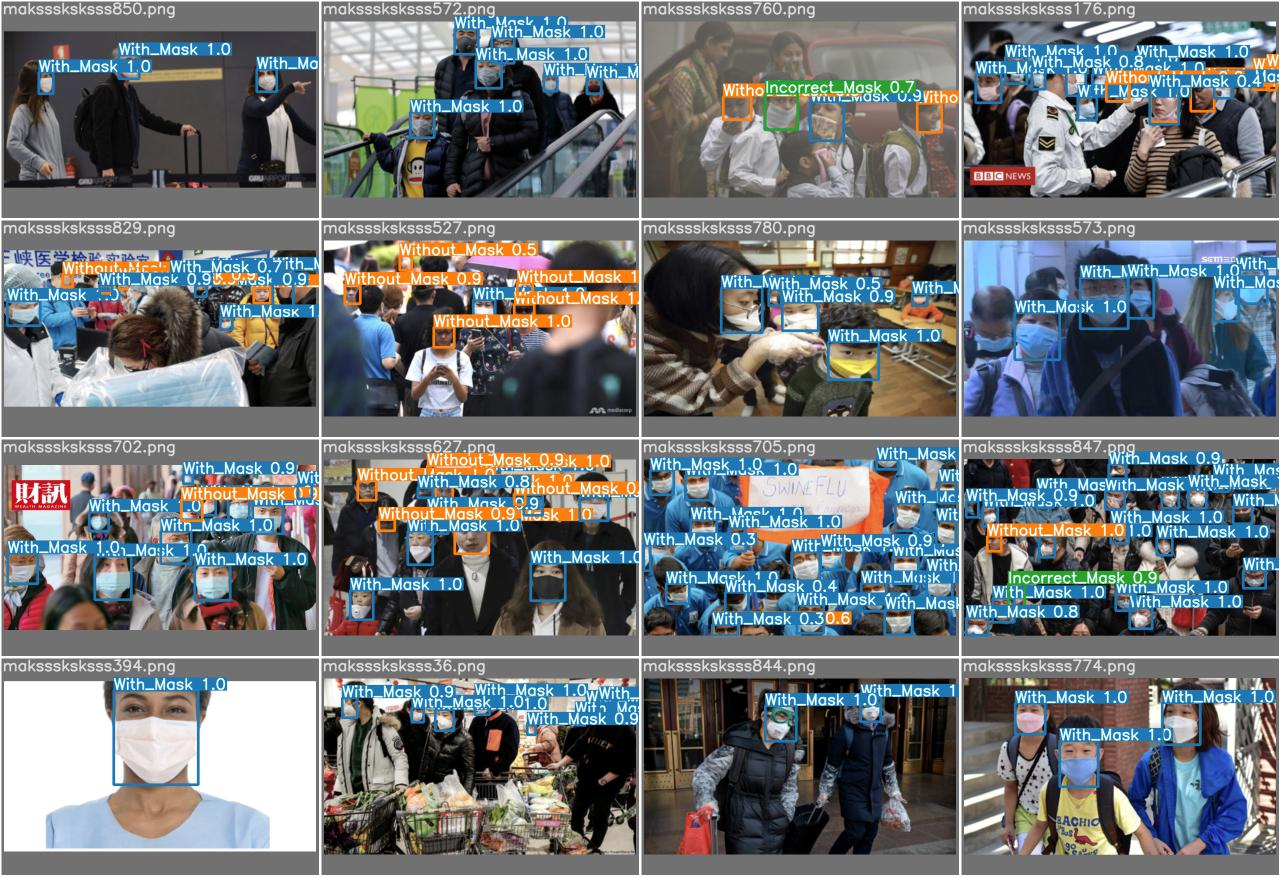

In [12]:
from IPython.display import Image, clear_output  # to display images
Image(filename='runs/test/exp16/test_batch0_pred.jpg', width=800)